# Getting Started with MLRUN
----------------------------

<a id='top'></a>
### **Understanding functions and running tasks locally**

**[intall mlrun](#install)**<br>
**[mlrun setup](#setup)**<br>
**[create and run a local function](#create-local)**<br>
**[create a new mlrun Task and run it](#create-new-task)**<br>
**[inspecting the run results and outputs](#inspecting)**<br>
**[using hyperparameter tasks](#using-hyperparamter-tasks)**<br>
**[running Task's through the cli](#tasks-cli)**<br>
**[inline code and running on multiple runtimes](#inline)**<br>
**[running locally in the notebook](#run-locally)**<br>
**[hyper parameters taken from a csv file](#run-csv)**

<a id="install" ></a>
______________________________________________

# **install**

In [1]:
# Uncomment this to install mlrun package, restart the kernel after

# !pip install mlrun

<a id="setup"></a>
______________________________________________

# **mlrun setup**

MLRun tracks jobs and artifacts, collecting metadata in local file directory or in a DB.

The DB/API path can be set using the environment variable ```MLRUN_DBPATH``` or the config object ```mlconf.dbpath```, we will try and get it from the environment.

**Note:** for _distributed jobs_ and and an _interactive UI_ you must use the `mlrun-api` service (and not the file DB).

For a local file DB, in the current folder:

In [1]:
from mlrun import run_local, new_task, mlconf
from os import path

mlconf.dbpath = mlconf.dbpath or "./"

For the ```mlrun-api``` service (in Kubernetes) use:

In [2]:
# uncomment for working with the DB
# mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

<a id="create-local"></a>
______________________________________________

# **create a new mlrun task and submit it to a local function**

An mlrun ```Task``` defines job inputs/outputs and metadata:
* input parameters
* hyper-parameters (or parameter files)
* input datasets
* default paths (for input/output)
* secrets (job credentials)
* ```Task``` metadata: name, project, labels, etc.

If a function supports multiple handlers (another term for method, function), we also need to define the specific handler (or set the `spec.default_handler`).

`Task` object have helper methods like `.with_params()`, `.with_secrets()`, `.with_input()`, `.set_label()` for conviniance.

This example shows how we can create a new task with various parameters and later use `.run()` to submit the task to our new function.<br>

artifacts from each run are stored in the `artifact_path` which can be set globally through environment var (`MLRUN_ARTIFACT_PATH`) or through the config, if its not already set we can create a directory and use it in our runs. Using `{{run.uid}}` in the path will allow us to create a unique directory per run, when we use pipelines we can use the `{{workflow.uid}}` template option.

> Note: artifact path can be a local path or a URL (starts with s3://, v3io://, etc.), if we want the artifacts to show in the UI the artifact path must be on a shared file or object media and should not be a relative path, on Iguazio platform the notebooks are always on the shared file system.

In [3]:
out = mlconf.artifact_path or path.abspath("./data")
# {{run.uid}} will be substituted with the run id, so output will be written to different directoried per run
artifact_path = path.join(out, "{{run.uid}}")

Then we create a new task and set its properties using helper methods:<br>
The [secrets `file`](secrets.txt) is a list of key=value properties 

In [4]:
task = (
    new_task(name="demo", params={"p1": 5}, artifact_path=artifact_path)
    .with_secrets("file", "secrets.txt")
    .set_label("type", "demo")
)

<a id="create-new-task"></a>
______________________________________________

### **run local code**
The following example creates a temp local function mapped to the **[training.py](training.py)** code file (located in the same folder as this notebook) and run it.

mlrun supports multiple _**runtimes**_ (handler, local, nuclio, job, spark, mpi, etc., see **[supported runtimes](https://github.com/mlrun/mlrun/tree/master/mlrun/runtimes)** for more details). _**local**_ runtime runs code in your local/notebook environment.

In [5]:
# run our task using our new function
run_object = run_local(task, command="training.py")

[mlrun] 2020-06-08 16:40:39,061 starting run demo uid=e9bdd9983067436eb080d9e61a458e4a  -> http://mlrun-api:8080
[mlrun] 2020-06-08 16:40:39,093 starting local run: training.py # main
[mlrun] 2020-06-08 16:40:41,607 logging run results to: http://mlrun-api:8080
Run: demo (uid=e9bdd9983067436eb080d9e61a458e4a)
Params: p1=5, p2=a-string
accesskey = 456
file
b"I'm a local input file\n"

[mlrun] 2020-06-08 16:40:41,679 log artifact model at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/model.txt, size: 10, db: Y
[mlrun] 2020-06-08 16:40:41,702 log artifact html_result at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/result.html, size: 17, db: Y
[mlrun] 2020-06-08 16:40:41,725 log artifact dataset at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/dataset.csv, size: 12, db: Y
[mlrun] 2020-06-08 16:40:41,748 log artifact chart at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/chart.html, size: 881, db: Y
[mlrun] 2020-06-08 16:4

to track results use .show() or .logs() or in CLI: 
!mlrun get run e9bdd9983067436eb080d9e61a458e4a --project default , !mlrun logs e9bdd9983067436eb080d9e61a458e4a --project default
[mlrun] 2020-06-08 16:40:42,215 run executed, status=completed


<b>Hover over the inputs/artifacts to see full link, or click to see the content !!!</b>
<a id="inspecting"></a>
______________________________________________

# **inspecting the run results and outputs**

Every ```run``` object (the result of a `.run()` method) has the following properties and methods:
* `.uid()`   - return the unique id
* `.state()` - return the last known state
* `.show()`  - show the latest task state and data in a visual widget (with hyper links and hints)
* `.outputs` - return a dict of the run results and artifact paths
* `.logs()`  - return the latest logs, use `Watch=False` to disable interactive mode in running tasks
* `.artifact(key)` - return full artifact details
* `.output(key)`   - return specific result or artifact (path)
* `.to_dict()`, `.to_yaml()`, `.to_json()` - convert the run object to dict/yaml/json

In [6]:
run_object.uid()

'e9bdd9983067436eb080d9e61a458e4a'

In [7]:
run_object.to_dict()

{'spec': {'parameters': {'p1': 5, 'p2': 'a-string'},
  'inputs': {'infile.txt': 'infile.txt'},
  'outputs': [],
  'output_path': '/User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a',
  'function': 'default/training',
  'secret_sources': [],
  'data_stores': []},
 'metadata': {'uid': 'e9bdd9983067436eb080d9e61a458e4a',
  'name': 'demo',
  'project': 'default',
  'labels': {'type': 'demo',
   'v3io_user': 'admin',
   'kind': '',
   'owner': 'admin',
   'host': 'jupyter-65887d7ffb-5jsn2',
   'framework': 'sklearn'},
  'iteration': 0},
 'status': {'state': 'completed',
  'results': {'accuracy': 10, 'loss': 15},
  'artifacts': [{'key': 'model',
    'kind': '',
    'iter': 0,
    'tree': 'e9bdd9983067436eb080d9e61a458e4a',
    'src_path': 'model.txt',
    'target_path': '/User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/model.txt',
    'hash': '8170b9a53bbb1f4d52733bc6824955e3a362d4a1',
    'size': 10,
    'db_key': 'demo_model'},
   {'key': 'html_result',
    'kind'

In [8]:
run_object.state()

'completed'

In [9]:
run_object.show()

In [10]:
run_object.outputs

{'accuracy': 10,
 'loss': 15,
 'model': '/User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/model.txt',
 'html_result': '/User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/result.html',
 'dataset': '/User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/dataset.csv',
 'chart': '/User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/chart.html',
 'mydf': 'store://default/demo_mydf#e9bdd9983067436eb080d9e61a458e4a'}

In [11]:
run_object.logs()

[mlrun] 2020-06-08 16:40:41,607 logging run results to: http://mlrun-api:8080
Run: demo (uid=e9bdd9983067436eb080d9e61a458e4a)
Params: p1=5, p2=a-string
accesskey = 456
file
b"I'm a local input file\n"

[mlrun] 2020-06-08 16:40:41,679 log artifact model at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/model.txt, size: 10, db: Y
[mlrun] 2020-06-08 16:40:41,702 log artifact html_result at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/result.html, size: 17, db: Y
[mlrun] 2020-06-08 16:40:41,725 log artifact dataset at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/dataset.csv, size: 12, db: Y
[mlrun] 2020-06-08 16:40:41,748 log artifact chart at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/chart.html, size: 881, db: Y
[mlrun] 2020-06-08 16:40:41,807 log artifact mydf at /User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/mydf.csv, size: 135, db: Y



''

In [12]:
run_object.artifact("dataset")

{'key': 'dataset',
 'kind': 'table',
 'iter': 0,
 'tree': 'e9bdd9983067436eb080d9e61a458e4a',
 'src_path': 'dataset.csv',
 'target_path': '/User/ml3/mlrun/examples/data/e9bdd9983067436eb080d9e61a458e4a/dataset.csv',
 'hash': 'c64e1ae504eb958a7a507e5d6fe43645a1bfb034',
 'viewer': 'table',
 'size': 12,
 'db_key': 'demo_dataset',
 'header': ['A', 'B', 'C']}

<a id="using-hyperparamter-tasks"></a>
______________________________________________

# **using hyper-parameter tasks**
In many cases we want to run the same function with different input values and select the best result.<br>

You can specify parameters with a list of values and mlrun will run all the parameter combinations as a single hyper-param task.<br>

Each unique run combination is called an _**iteration**_, where '0' iteration is the parent task.

Use `.with_hyper_params()` and provide lists or values, we use the selector string to indicate which will iteration will be selected as the winning result (indicated using [```min``` or ```max```].[```output-value```])

In [13]:
run = run_local(
    task.with_hyper_params({"p2": [5, 2, 3]}, "min.loss"), command="training.py"
)

[mlrun] 2020-06-08 16:43:26,876 starting run demo uid=9f19c02aa8e4438bbf1ad5fe1f88740a  -> http://mlrun-api:8080
[mlrun] 2020-06-08 16:43:26,906 starting local run: training.py # main
> --------------- Iteration: (1) ---------------
[mlrun] 2020-06-08 16:43:29,489 logging run results to: http://mlrun-api:8080
Run: demo (uid=9f19c02aa8e4438bbf1ad5fe1f88740a-1)
Params: p1=5, p2=5
accesskey = 456
file
b"I'm a local input file\n"

[mlrun] 2020-06-08 16:43:29,567 log artifact model at /User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/model.txt, size: 10, db: Y
[mlrun] 2020-06-08 16:43:29,597 log artifact html_result at /User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/result.html, size: 17, db: Y
[mlrun] 2020-06-08 16:43:29,622 log artifact dataset at /User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/dataset.csv, size: 12, db: Y
[mlrun] 2020-06-08 16:43:29,646 log artifact chart at /User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/

to track results use .show() or .logs() or in CLI: 
!mlrun get run 9f19c02aa8e4438bbf1ad5fe1f88740a --project default , !mlrun logs 9f19c02aa8e4438bbf1ad5fe1f88740a --project default
[mlrun] 2020-06-08 16:43:36,298 run executed, status=completed


In [14]:
run.outputs

{'best_iteration': 1,
 'accuracy': 10,
 'loss': 15,
 'model': '/User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/model.txt',
 'html_result': '/User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/result.html',
 'dataset': '/User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/dataset.csv',
 'chart': '/User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/1/chart.html',
 'mydf': 'store://default/demo_mydf#9f19c02aa8e4438bbf1ad5fe1f88740a',
 'iteration_results': '/User/ml3/mlrun/examples/data/9f19c02aa8e4438bbf1ad5fe1f88740a/iteration_results.csv'}

<a id="tasks-cli"></a>
______________________________________________

# **running tasks through the cli**

In [15]:
%env MLRUN_DBPATH={mlconf.dbpath}

env: MLRUN_DBPATH=http://mlrun-api:8080


In [16]:
!mlrun run --name train_hyper -x p1="[3,7,5]" --selector max.accuracy -p p2=5 --out-path {artifact_path} training.py
if _exit_code != 0:
    raise RuntimeError()

[mlrun] 2020-06-08 16:44:03,966 starting run train_hyper uid=3d2ea381861346cba591fe9165e7279d  -> http://mlrun-api:8080
[mlrun] 2020-06-08 16:44:03,993 starting local run: training.py # main
> --------------- Iteration: (1) ---------------
[mlrun] 2020-06-08 16:44:06,481 logging run results to: http://mlrun-api:8080
Run: train_hyper (uid=3d2ea381861346cba591fe9165e7279d-1)
Params: p1=3, p2=5
accesskey = None
file
b"I'm a local input file\n"

[mlrun] 2020-06-08 16:44:06,544 log artifact model at /User/ml3/mlrun/examples/data/3d2ea381861346cba591fe9165e7279d/1/model.txt, size: 10, db: Y
[mlrun] 2020-06-08 16:44:06,574 log artifact html_result at /User/ml3/mlrun/examples/data/3d2ea381861346cba591fe9165e7279d/1/result.html, size: 17, db: Y
[mlrun] 2020-06-08 16:44:06,601 log artifact dataset at /User/ml3/mlrun/examples/data/3d2ea381861346cba591fe9165e7279d/1/dataset.csv, size: 12, db: Y
[mlrun] 2020-06-08 16:44:06,625 log artifact chart at /User/ml3/mlrun/examples/data/3d2ea381861346cba591

In [17]:
# see other CLI commands
!mlrun
if _exit_code != 0:
    raise RuntimeError()

Usage: mlrun [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  build    Build a container image from code and requirements.
  clean    Clean runtime resources
  config   Show configuration & exit
  db       Run HTTP api/database server
  deploy   Deploy model or function
  get      List/get one or more object per kind/class.
  logs     Get or watch task logs
  project  load and/or run a project
  run      Execute a task and inject parameters.
  version  get mlrun version
  watch    Read current or previous task (pod) logs.


<a id="inline"></a>
______________________________________________

# **using (inline) code and running on different runtimes**

In [20]:
from mlrun.artifacts import ChartArtifact, PlotArtifact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# define a function with spec as parameter
import time


def handler(context, p1=1, p2="xx"):
    """this is a simple function

    :param p1:  first param
    :param p2:  another param
    """
    # access input metadata, values, and inputs
    print(f"Run: {context.name} (uid={context.uid})")
    print(f"Params: p1={p1}, p2={p2}")

    time.sleep(1)

    # log the run results (scalar values)
    context.log_result("accuracy", p1 * 2)
    context.log_result("loss", p1 * 3)

    # add a lable/tag to this run
    context.set_label("category", "tests")

    # create a matplot figure and store as artifact
    fig, ax = plt.subplots()
    np.random.seed(0)
    x, y = np.random.normal(size=(2, 200))
    color, size = np.random.random((2, 200))
    ax.scatter(x, y, c=color, s=500 * size, alpha=0.3)
    ax.grid(color="lightgray", alpha=0.7)

    context.log_artifact(PlotArtifact("myfig", body=fig, title="my plot"))

    # create a dataframe artifact
    df = pd.DataFrame([{"A": 10, "B": 100}, {"A": 11, "B": 110}, {"A": 12, "B": 120}])
    context.log_dataset("mydf", df=df)

    # Log an ML Model artifact
    context.log_model(
        "mymodel",
        body=b"abc is 123",
        model_file="model.txt",
        model_dir="data",
        metrics={"accuracy": 0.85},
        parameters={"xx": "abc"},
        labels={"framework": "xgboost"},
    )

    return "my resp"

<a id="run-locally"></a>
______________________________________________

# **run locally in the notebook**

[mlrun] 2020-06-08 16:45:44,526 starting run demo2 uid=cfeecfa9880b4047b08685a0e62bddaa  -> http://mlrun-api:8080
Run: demo2 (uid=cfeecfa9880b4047b08685a0e62bddaa)
Params: p1=7, p2=xx
[mlrun] 2020-06-08 16:45:45,641 log artifact myfig at /User/ml3/mlrun/examples/data/cfeecfa9880b4047b08685a0e62bddaa/myfig.html, size: 76607, db: Y
[mlrun] 2020-06-08 16:45:45,671 log artifact mydf at /User/ml3/mlrun/examples/data/cfeecfa9880b4047b08685a0e62bddaa/mydf.csv, size: 32, db: Y
[mlrun] 2020-06-08 16:45:45,690 log artifact mymodel at /User/ml3/mlrun/examples/data/cfeecfa9880b4047b08685a0e62bddaa/data/, size: 10, db: Y



to track results use .show() or .logs() or in CLI: 
!mlrun get run cfeecfa9880b4047b08685a0e62bddaa --project default , !mlrun logs cfeecfa9880b4047b08685a0e62bddaa --project default
[mlrun] 2020-06-08 16:45:45,726 run executed, status=completed


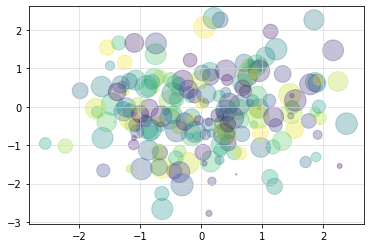

In [21]:
task = new_task(name="demo2", handler=handler, artifact_path=artifact_path).with_params(
    p1=7
)
run = run_local(task)

<a id="run-csv"></a>
______________________________________________

# **run with hyper parameters taken from a csv file**

[mlrun] 2020-06-08 16:45:48,437 starting run demo2 uid=14e1be4e4b0f4a42b252cc906b28e329  -> http://mlrun-api:8080
> --------------- Iteration: (1) ---------------
Run: demo2 (uid=14e1be4e4b0f4a42b252cc906b28e329-1)
Params: p1=11, p2=33
[mlrun] 2020-06-08 16:45:49,557 log artifact myfig at /User/ml3/mlrun/examples/data/14e1be4e4b0f4a42b252cc906b28e329/1/myfig.html, size: 76607, db: Y
[mlrun] 2020-06-08 16:45:49,592 log artifact mydf at /User/ml3/mlrun/examples/data/14e1be4e4b0f4a42b252cc906b28e329/1/mydf.csv, size: 32, db: Y
[mlrun] 2020-06-08 16:45:49,614 log artifact mymodel at /User/ml3/mlrun/examples/data/14e1be4e4b0f4a42b252cc906b28e329/1/data/, size: 10, db: Y

> --------------- Iteration: (2) ---------------
Run: demo2 (uid=14e1be4e4b0f4a42b252cc906b28e329-2)
Params: p1=12, p2=44
[mlrun] 2020-06-08 16:45:50,741 log artifact myfig at /User/ml3/mlrun/examples/data/14e1be4e4b0f4a42b252cc906b28e329/2/myfig.html, size: 76607, db: Y
[mlrun] 2020-06-08 16:45:50,781 log artifact mydf at 

to track results use .show() or .logs() or in CLI: 
!mlrun get run 14e1be4e4b0f4a42b252cc906b28e329 --project default , !mlrun logs 14e1be4e4b0f4a42b252cc906b28e329 --project default
[mlrun] 2020-06-08 16:45:52,109 run executed, status=completed


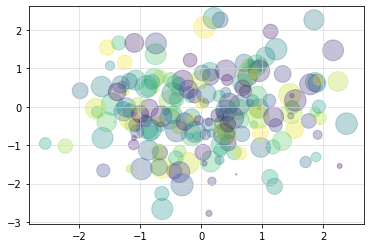

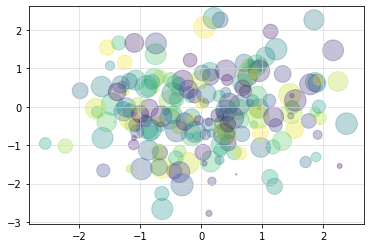

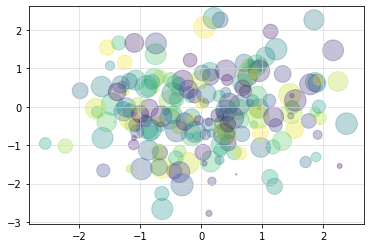

In [22]:
task = new_task(
    name="demo2", handler=handler, artifact_path=artifact_path
).with_param_file("params.csv", "max.accuracy")
run = run_local(task)